In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

In [3]:
with open('./datasets/ships-data/shipsnet.json') as json_data:
    d = json.load(json_data)

In [4]:
np.unique(d['labels'])

array([0, 1])

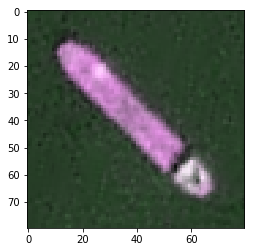

In [5]:
ii = 5
img = np.array([[r,g,b] for r,g,b in zip(d['data'][ii][0:6400],d['data'][ii][6400:12800],d['data'][ii][:12800])]).reshape([80,80,3])
plt.imshow(img)

In [6]:
data = []
for fimg in d['data']:
    data.append(np.array([[fimg[ii],fimg[ii+6400],fimg[ii+12800]] for ii in range(len(fimg)//3)], dtype=np.uint8).reshape([80,80,3]))

In [7]:
zdata = list(zip(data,d["labels"]))
random.shuffle(zdata)
data, labels = zip(*zdata)

In [89]:
# Split the data
train_data = np.array(data[0:3500], dtype=np.float32)
test_data = np.array(data[3500:], dtype=np.float32)
train_labels = np.array(labels[0:3500])
test_labels = np.array(labels[3500:])

In [8]:
import tensorflow as tf

In [9]:
# Training Parameters
learning_rate = 0.001
num_steps = 2000
batch_size = 128

# Network Parameters
num_input = 4000 
num_classes = 2
dropout = 0.4

In [10]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out

In [11]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False,
                            is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True,
                           is_training=False)

    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)

    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes)

        # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op,
                                  global_step=tf.train.get_global_step())

    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=pred_classes,
        loss=loss_op,
        train_op=train_op,
        eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [12]:
def train(tdata, tlabels, tsdata, tslabels):
    # Build the Estimator
    model = tf.estimator.Estimator(model_fn)

    # Define the input function for training
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'images': tdata}, y=np.array(tlabels),
        batch_size=batch_size, num_epochs=None, shuffle=True)
    # Train the Model
    model.train(input_fn, steps=num_steps)

    # Evaluate the Model
    # Define the input function for evaluating
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'images': tsdata}, y=tslabels,
        batch_size=batch_size, shuffle=False)
    # Use the Estimator 'evaluate' method
    e = model.evaluate(input_fn)

    print("Testing Accuracy:", e['accuracy'])

In [90]:
train(train_data, train_labels, test_data, test_labels)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/jl/pc72bld16gn0mlgq604hqjt00000gn/T/tmp4o0z2eii', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x16b342240>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create Chec

In [14]:
import cv2

In [15]:
gray_data = []
for image in data:
    gray_data.append(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))

In [16]:
# Split the data
gray_train_data = np.array(data[0:3500], dtype=np.float32)
gray_test_data = np.array(data[3500:], dtype=np.float32)
gray_train_labels = np.array(labels[0:3500])
gray_test_labels = np.array(labels[3500:])

In [17]:
train(gray_train_data, gray_train_labels, gray_test_data, gray_test_labels)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/jl/pc72bld16gn0mlgq604hqjt00000gn/T/tmp2_9z834f', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x179d7c3c8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create Chec

(<matplotlib.axes._subplots.AxesSubplot at 0x169f8d160>,
 <matplotlib.image.AxesImage at 0x16ab04e80>)

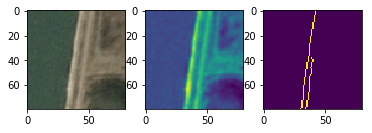

In [95]:
# load the image from disk, convert it to grayscale, blur it,
# and apply edge detection to reveal the outline of the pill
ii=112
ii=27
gr = cv2.cvtColor(np.array(train_data[ii], dtype=np.uint8), cv2.COLOR_BGR2GRAY)
gr = cv2.GaussianBlur(gr, (3, 3), 0)
edged = cv2.Canny(gr, 100, 200)
plt.subplot(131),plt.imshow(np.array(train_data[ii], dtype=np.uint8))
plt.subplot(132),plt.imshow(gr)
plt.subplot(133),plt.imshow(edged)

In [73]:
edged_data = []
for image in data:
    gr = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gr = cv2.GaussianBlur(gr, (3, 3), 0)
    edged = cv2.Canny(gr, 100, 200)
    edged_data.append(np.dstack( ( image, edged) ) )

In [75]:
# Split the data
edged_train_data = np.array(edged_data[0:3500], dtype=np.float32)
edged_test_data = np.array(edged_data[3500:], dtype=np.float32)
edged_train_labels = np.array(labels[0:3500])
edged_test_labels = np.array(labels[3500:])

In [76]:
train(edged_train_data, edged_train_labels, edged_test_data, edged_test_labels)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/jl/pc72bld16gn0mlgq604hqjt00000gn/T/tmp9s74px2y', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x16a3f89b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create Chec

In [82]:
just_edged_data = []
for image in data:
    gr = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gr = cv2.GaussianBlur(gr, (3, 3), 0)
    edged = cv2.Canny(gr, 100, 200)
    just_edged_data.append(edged)

In [86]:
# Split the data
just_edged_train_data = np.array(just_edged_data[0:3500], dtype=np.float32).reshape([3500,80,80,1])
just_edged_test_data = np.array(just_edged_data[3500:], dtype=np.float32).reshape([500,80,80,1])
just_edged_train_labels = np.array(labels[0:3500])
just_edged_test_labels = np.array(labels[3500:])

In [87]:
train(just_edged_train_data, just_edged_train_labels, just_edged_test_data, just_edged_test_labels)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/jl/pc72bld16gn0mlgq604hqjt00000gn/T/tmprnph2e1n', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x16a65a588>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create Chec

In [105]:
rot45_data = []
rows,cols = 80,80
M = cv2.getRotationMatrix2D((cols/2,rows/2),45,1)

for image,lb in zip(train_data,train_labels):
    dst = cv2.warpAffine(image,M,(cols,rows))
    rot45_data.append(dst)

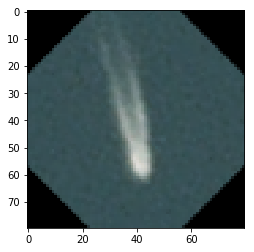

In [108]:
plt.imshow(np.array(rot45_data[6], dtype=np.uint8))

In [109]:
doub_data = np.concatenate((rot45_data,train_data))
print(doub_data.shape)

(7000, 80, 80, 3)


In [123]:
zdata = list(zip(doub_data,np.concatenate((train_labels,train_labels))))
random.shuffle(zdata)
doub_data, doub_labels = zip(*zdata)

In [124]:
train_doub_data = np.array(doub_data, dtype=np.float32)

In [125]:
# Training Parameters
learning_rate = 0.001
num_steps = 4000
batch_size = 128

# Network Parameters
num_input = 8000 
num_classes = 2
dropout = 0.4

In [126]:
train(train_doub_data,doub_labels, test_data, test_labels)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/jl/pc72bld16gn0mlgq604hqjt00000gn/T/tmpy_3s69cm', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x16ad9c240>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create Chec